# SET UP

In [1]:
import pandas as pd
import functions
from scipy.stats import iqr
import umap
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

In [2]:
ct_to_col = {
    'CD4 T': '#1f77b4',
    'CD14 Monocytes': '#ff7f0e',
    'B': '#279e68',
    'CD8 T': '#d62728',
    'FCGR3A Monocytes': '#aa40fc',
    'NK': '#8c564b',
    'Dendritic': '#e377c2',
    'Megakaryocytes': '#b5bd61'
}

# DATA PREPARATION

## FLUXOMES DATAFRAME

In [3]:
fluxes_df = pd.read_csv("/Users/claudiavicentecomorera/Desktop/TFG/Results/PBMC3k/pfba_fluxes_pbmc3k.csv", index_col = 0)
fluxes_ni_df = pd.read_csv("/Users/claudiavicentecomorera/Desktop/TFG/Results_ni/pfba_fluxes_pbmc3k.csv", index_col = 0)
fluxes_ni_df = fluxes_ni_df.fillna(0)

print(fluxes_df.shape)
print(fluxes_ni_df.shape)

(2638, 10600)
(2638, 2948)


## FLUXES TRANSFORMATION

In [4]:
t_fluxes_df = fluxes_df.applymap(functions.flux_transformer)
t_fluxes_ni_df = fluxes_ni_df.applymap(functions.flux_transformer)

## REACTIONS FILTERING

In [5]:
rx = pd.DataFrame(columns=['Reaction', 'IQR'])
for col in t_fluxes_df.columns:
    IQR = iqr(t_fluxes_df[col])
    if IQR != 0:
        rx = pd.concat([rx, pd.DataFrame({'Reaction': [col], 'IQR': [IQR]})], ignore_index = True)

ft_fluxes_df = t_fluxes_df[rx['Reaction']]
rx

,Reaction,IQR
0,3HBCDm,1.332268e-15
1,ABTD,9.965784e+00
2,ACACT1rm,6.769585e-14
3,ACACT1x,6.547685e+00
4,AKGMALtm,1.716960e-13
...,...,...
256,EX_gln_L[e],5.842629e+00
257,sink_ser_L[c],6.382679e+00
258,r1418,9.540692e+00
259,EX_leu_L[e],5.836875e+00


In [6]:
rx_ni = pd.DataFrame(columns=['Reaction', 'IQR'])
for col in t_fluxes_ni_df.columns:
    IQR = iqr(t_fluxes_ni_df[col])
    if IQR != 0:
        rx_ni = pd.concat([rx_ni, pd.DataFrame({'Reaction': [col], 'IQR': [IQR]})], ignore_index = True)

ft_fluxes_ni_df = t_fluxes_ni_df[rx_ni['Reaction']]
rx_ni

,Reaction,IQR
0,AMPDA,1.210333
1,CDIPTr,0.209329
2,CLS_hs,0.209329
3,CYTK14,1.931703
4,DAGK_hs,0.219091
...,...,...
109,DM_akg[c],3.301000
110,EX_h[e],8.314657
111,L_LACt2r,9.939482
112,L_LACt4r,1.194415


# RESULTS VISUALIZATION

## COLOR MAPPING

In [7]:
c_labs = pd.read_csv('/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/clabs_pbmc.csv')
d_clabs = {type: group['Cell_Name'].tolist() for type, group in c_labs.groupby('Cluster_Label')}     
colors = [next((ct_to_col[type] for type, cells in d_clabs.items() if cell in cells)) for cell in fluxes_df.index]

In [8]:
l = []; l_labs = []

for key, value in d_clabs.items():
    l.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = ct_to_col[key], markersize = 10))
    l_labs.append(key)

## UMAP PROJECTION

/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/claudiavicentecomorera/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


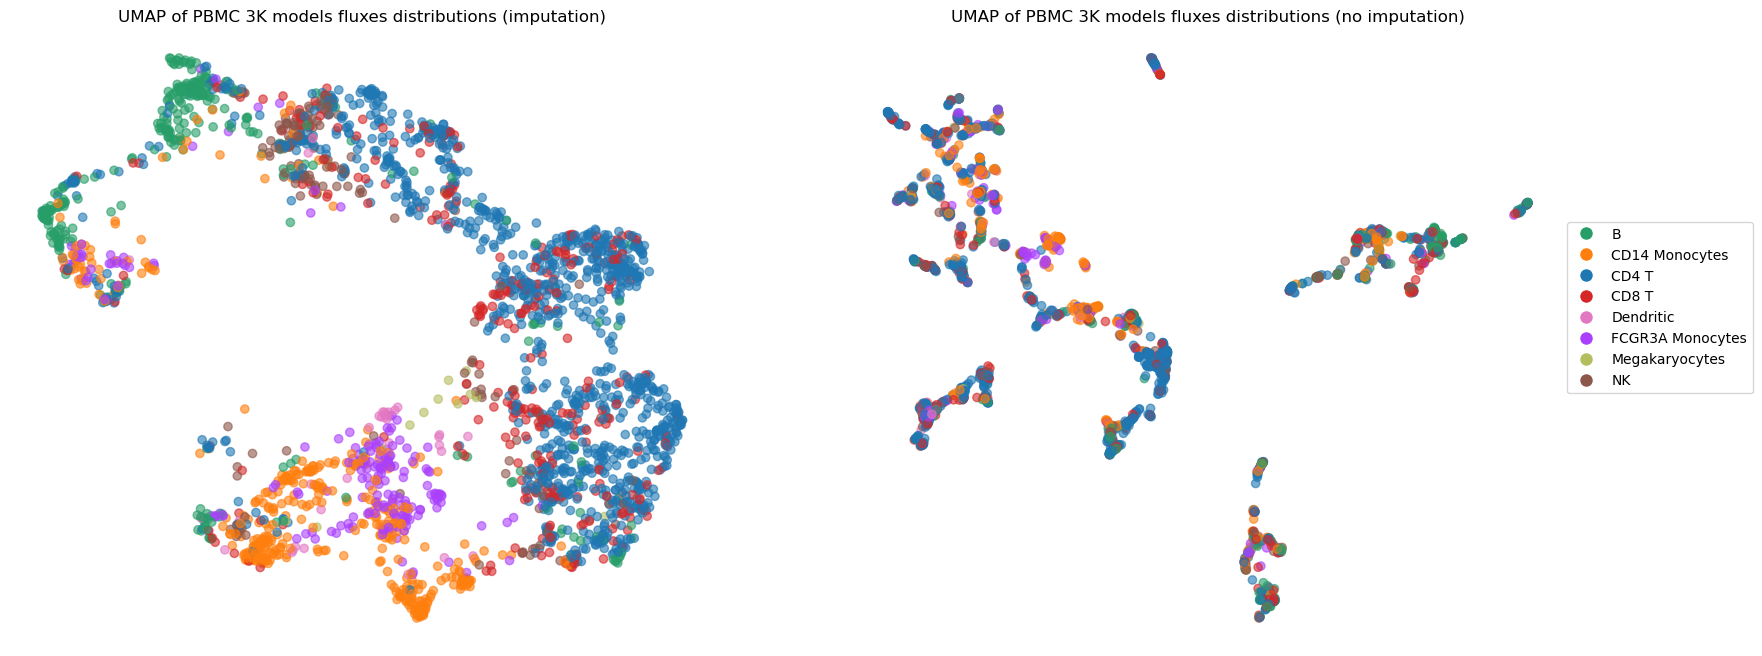

In [9]:
reducer = umap.UMAP(n_neighbors = 30, min_dist = 0.1, random_state = 42)
embedding = reducer.fit_transform(ft_fluxes_df)
embedding_ni = reducer.fit_transform(ft_fluxes_ni_df)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].scatter(embedding[:, 0], embedding[:, 1], c = colors, alpha = .6)
axes[0].legend(l, l_labs)
axes[0].axis('off') 
axes[0].set_title('UMAP of PBMC 3K models fluxes distributions (imputation)')
axes[0].legend_.remove()
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

axes[1].scatter(embedding_ni[:, 0], embedding_ni[:, 1], c = colors, alpha = .6)
axes[1].legend(l, l_labs, bbox_to_anchor = (1, 0.7))
axes[1].axis('off') 
axes[1].set_title('UMAP of PBMC 3K models fluxes distributions (no imputation)')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

plt.show()

# FLUXES DATAFRAME DISTRIBUTION

In [10]:
f_array = ft_fluxes_df.values.flatten()
f_ni_array = ft_fluxes_ni_df.values.flatten()

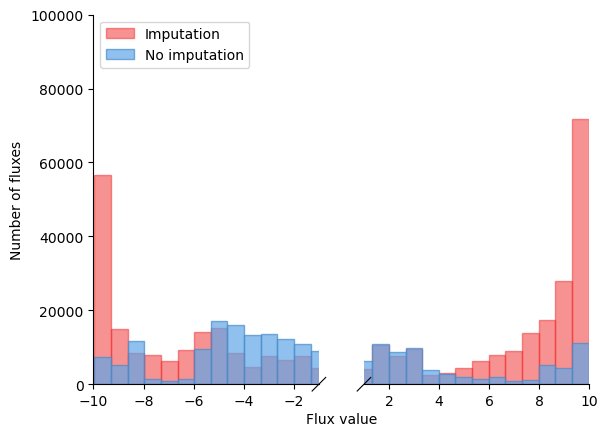

In [11]:
bax = brokenaxes(xlims = ((-10, -1), (1, 10)))

bax.hist(f_array[~((f_array > -1) & (f_array < 1))], bins = 30, alpha = 0.5, color = '#F12727', edgecolor = '#F12727', label = 'Imputation')
bax.hist(f_ni_array[~((f_ni_array > -1) & (f_ni_array < 1))], bins = 30, alpha = 0.7, color = '#60A6E7', edgecolor = '#468BCB', label = 'No imputation')
bax.set_ylabel('Number of fluxes', labelpad=50)
bax.set_xlabel('Flux value', labelpad=20)
bax.set_ylim(0,100000)
bax.legend(loc = 'upper left')

plt.show()